In [1]:
import sys 
sys.path.append('..')

import torch 
import rlcard 
from rlcard.agents import NFSPAgent

In [2]:
state_shape = torch.Size([12])

env = rlcard.make(
    'leduc-holdem',
    config={
        'seed': 0,
    }
)
agent = NFSPAgent(
                num_actions=env.num_actions,
                state_shape=env.state_shape[0],
                hidden_layers_sizes=[64,64],
                q_mlp_layers=[64,64],
                device='cpu',
                estimator_network='mlp'
            )

In [3]:
import os
import argparse

import torch

import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

In [4]:
''' An example of training a reinforcement learning agent on the environments in RLCard
'''


def train(args):

    # Check whether gpu is available
    device = get_device()
        
    # Seed numpy, torch, random
    set_seed(args.seed)

    # Make the environment with seed
    env = rlcard.make(
        args.env,
        config={
            'seed': args.seed,
        }
    )

    # Initialize the agent and use random agents as opponents
    if args.algorithm == 'dqn':
        from rlcard.agents import DQNAgent
        if args.load_checkpoint_path != "":
            agent = DQNAgent.from_checkpoint(checkpoint=torch.load(args.load_checkpoint_path))
        else:
            agent = DQNAgent(
                num_actions=env.num_actions,
                state_shape=env.state_shape[0],
                mlp_layers=[64,64],
                device=device,
                save_path=args.log_dir,
                save_every=args.save_every,
                estimator_network=args.estimator_network,
                num_layers=1
            )
    elif args.algorithm == 'nfsp':
        from rlcard.agents import NFSPAgent
        if args.load_checkpoint_path != "":
            agent = NFSPAgent.from_checkpoint(checkpoint=torch.load(args.load_checkpoint_path))
        else:
            agent = NFSPAgent(
                num_actions=env.num_actions,
                state_shape=env.state_shape[0],
                hidden_layers_sizes=[64,64],
                q_mlp_layers=[64,64],
                device=device,
                save_path=args.log_dir,
                save_every=args.save_every, 
                estimator_network=args.estimator_network,
            )
    elif args.algorithm == 'cfr': 
        from rlcard.agents import CFRAgent
        if args.load_checkpoint_path != "":
            agent = CFRAgent.from_checkpoint(checkpoint=torch.load(args.load_checkpoint_path))
        else:
            agent = CFRAgent(
                env,
                device=device,
                save_path=args.log_dir,
                save_every=args.save_every
            )
    
    agents = [agent]
    for _ in range(1, env.num_players):
        agents.append(RandomAgent(num_actions=env.num_actions))
    env.set_agents(agents)

    # Start training
    with Logger(args.log_dir) as logger:
        for episode in range(args.num_episodes):

            if args.algorithm == 'nfsp':
                agents[0].sample_episode_policy()

            # Generate data from the environment
            trajectories, payoffs = env.run(is_training=True)

            # Reorganize the data to be state, action, reward, next_state, done
            trajectories = reorganize(trajectories, payoffs)

            # Feed transitions into agent memory, and train the agent
            # Here, we assume that DQN always plays the first position
            # and the other players play randomly (if any)
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance. Play with random agents.
            if episode % args.evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        args.num_eval_games,
                    )[0]
                )

        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path

    # Plot the learning curve
    plot_curve(csv_path, fig_path, args.algorithm)

    # Save model
    save_path = os.path.join(args.log_dir, 'model.pth')
    torch.save(agent, save_path)
    print('Model saved in', save_path)


In [8]:
parser = argparse.ArgumentParser("DQN/NFSP example in RLCard")
env = 'leduc-holdem'
algorithm = 'nfsp'
cuda = ''
seed = 42
num_episodes = 5000
num_eval_games = 2000
evaluate_every = 100
log_dir = 'experiments/leduc_holdem_dqn_result/'
load_checkpoint_path = ""
save_every = -1

os.environ["CUDA_VISIBLE_DEVICES"] = cuda

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict({
    'env': env,
    'algorithm': algorithm,
    'seed': seed,
    'num_episodes': num_episodes,
    'num_eval_games': num_eval_games,
    'evaluate_every': evaluate_every,
    'log_dir': log_dir,
    'load_checkpoint_path': load_checkpoint_path,
    'save_every': save_every, 
    'estimator_network': 'mlp',
})

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.105
----------------------------------------
INFO - Step 100, rl-loss: 1.1808809041976929
INFO - Copied model parameters to target network.
INFO - Step 133, rl-loss: 6.0292611122131353
----------------------------------------
  episode      |  100
  reward       |  0.011
----------------------------------------
INFO - Step 263, rl-loss: 7.9969210624694825
----------------------------------------
  episode      |  200
  reward       |  0.116
----------------------------------------
INFO - Step 400, rl-loss: 8.2111606597900397
----------------------------------------
  episode      |  300
  reward       |  0.08975
----------------------------------------
INFO - Step 537, rl-loss: 11.862444877624512
----------------------------------------
  episode      |  400
  reward       |  0.09175
----------------------------------------
INFO - Step 667, rl-loss: 12.629177093505864
--------------

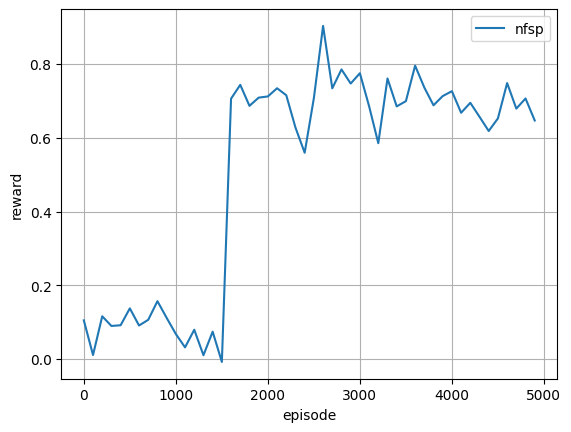

In [9]:
train(args)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.105
----------------------------------------
INFO - Step 100, rl-loss: 1.1808809041976929
INFO - Copied model parameters to target network.
INFO - Step 133, rl-loss: 6.0292611122131353
----------------------------------------
  episode      |  100
  reward       |  0.011
----------------------------------------
INFO - Step 263, rl-loss: 7.9969210624694825
----------------------------------------
  episode      |  200
  reward       |  0.116
----------------------------------------
INFO - Step 400, rl-loss: 8.2111606597900397
----------------------------------------
  episode      |  300
  reward       |  0.08975
----------------------------------------
INFO - Step 537, rl-loss: 11.862444877624512
----------------------------------------
  episode      |  400
  reward       |  0.09175
----------------------------------------
INFO - Step 667, rl-loss: 12.629177093505864
--------------

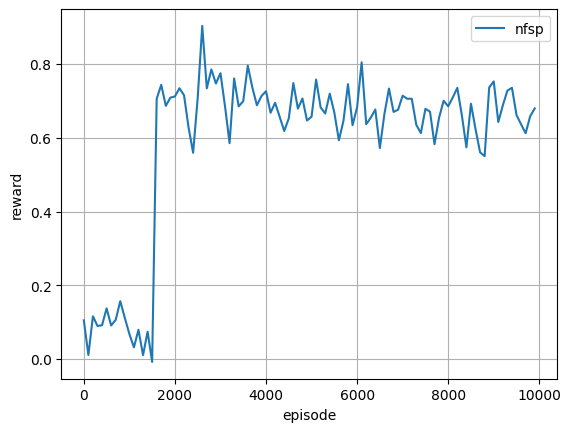

In [ ]:
train(args)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.4405
----------------------------------------
INFO - Step 100, rl-loss: 3.6029632091522217
INFO - Copied model parameters to target network.

INFO - Saved model checkpoint.
INFO - Step 101, rl-loss: 4.56651496887207
INFO - Saved model checkpoint.
INFO - Step 102, rl-loss: 6.015787601470947
INFO - Saved model checkpoint.
INFO - Step 103, rl-loss: 4.814128875732422
INFO - Saved model checkpoint.
INFO - Step 104, rl-loss: 2.9227681159973145
INFO - Saved model checkpoint.
INFO - Step 105, rl-loss: 1.8799431324005127
INFO - Saved model checkpoint.
INFO - Step 106, rl-loss: 3.676807403564453
INFO - Saved model checkpoint.
INFO - Step 107, rl-loss: 4.914892673492432
INFO - Saved model checkpoint.
INFO - Step 108, rl-loss: 2.2912843227386475
INFO - Saved model checkpoint.
INFO - Step 109, rl-loss: 4.5768914222717285
INFO - Saved model checkpoint.
INFO - Step 110, rl-loss: 2.988481044769287


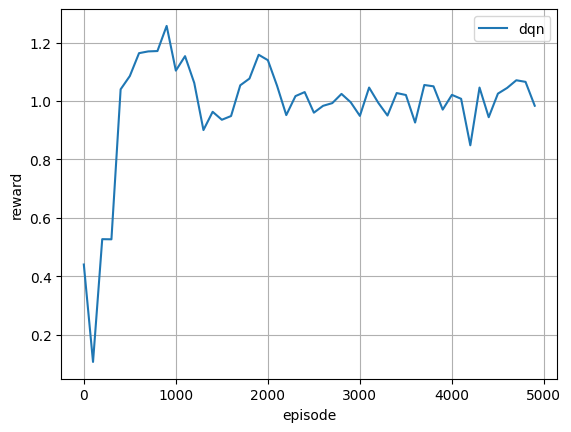

In [ ]:
train(args)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  -0.5095
----------------------------------------
INFO - Step 100, rl-loss: 4.648682594299316
INFO - Copied model parameters to target network.

INFO - Saved model checkpoint.
INFO - Step 101, rl-loss: 5.826885223388672
INFO - Saved model checkpoint.
INFO - Step 102, rl-loss: 4.730411052703857
INFO - Saved model checkpoint.
INFO - Step 103, rl-loss: 8.58011245727539
INFO - Saved model checkpoint.
INFO - Step 104, rl-loss: 3.2929258346557617
INFO - Saved model checkpoint.
INFO - Step 105, rl-loss: 1.7539842128753662
INFO - Saved model checkpoint.
INFO - Step 106, rl-loss: 4.626237392425537
INFO - Saved model checkpoint.
INFO - Step 107, rl-loss: 4.4548444747924805
INFO - Saved model checkpoint.
INFO - Step 108, rl-loss: 2.537238359451294
INFO - Saved model checkpoint.
INFO - Step 109, rl-loss: 3.601485013961792
INFO - Saved model checkpoint.
INFO - Step 110, rl-loss: 2.024397134780884
I

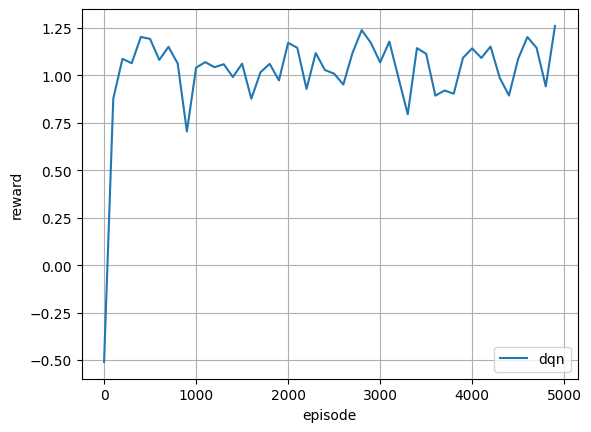

In [ ]:
train(args)